TO DO : 

- Improve upon the preprocessing [ADDED]
- Create the pipeline
- Try out polynomial regression as well
- make sure all of it makes sense
- do some interpretation at the end.

# Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv("preprocessed_airbnb_data.csv")
df.head()

,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,room_type_Private room,room_type_Shared room,city_athens,city_barcelona,city_berlin,city_budapest,city_lisbon,city_london,city_paris,city_rome,city_vienna,day_type_weekends,price
0,0,1,2.0,0,1,0,0.638184,0.041559,1,0.198180,0.177775,4.166708,6.846473,1,0,0,0,0,0,0,0,0,0,0,0,5.268032
1,0,1,4.0,0,0,0,-1.456366,-0.852751,1,0.018732,0.016614,33.421209,58.342928,1,0,0,0,0,0,0,0,0,0,0,0,5.841356
2,0,1,2.0,0,0,1,-0.409091,-0.629173,1,0.226885,0.255711,3.985908,6.646700,1,0,0,0,0,0,0,0,0,0,0,0,5.576333
3,0,1,4.0,0,0,1,-0.409091,-0.293807,2,0.014635,0.030661,26.119108,60.973565,1,0,0,0,0,0,0,0,0,0,0,0,6.071960
4,0,1,2.0,1,0,0,0.638184,0.600503,1,0.020962,0.022170,29.272733,56.811677,1,0,0,0,0,0,0,0,0,0,0,0,6.185288


# Train Validation and Test splits

Validation set is useful for hyperparameter tuning and model selection.

80% for `training`, 20% for `testing`

I am doing stratfied K fold cross validation in Grid search. Therefore, I will split the data into training and test only. The Grid Search process used kfold to split into training and validation by itself.

In [3]:
len(df.columns)

26

In [4]:
X = df.drop('price', axis=1)
y = df['price']

# split: train + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (41365, 25)
Testing set shape: (10342, 25)


# Creating pipeline

In [11]:
# Define pipelines for each model
models = {
    'linear_regression': LinearRegression(),
    'ridge': Ridge(),
#     'lasso': Lasso(),
#     'random_forest': RandomForestRegressor(),
#     'gradient_boosting': GradientBoostingRegressor(),
#     'svr': SVR(),
#     'decision_tree': DecisionTreeRegressor(),
#     'xgboost': XGBRegressor(),
#     'polynomial_regression': 
}

In [12]:
# Define parameter grids for hyperparameter tuning
# param_grids = {
#     'Linear Regression': {},
#     'Ridge': {'regressor__alpha': [0.1, 1.0, 10.0]},
# #     'Lasso': {'regressor__alpha': [0.1, 1.0, 10.0]},
# #     'Random Forest': {'regressor__n_estimators': [50, 100, 200], 'regressor__max_depth': [None, 10, 20]}, # takes a long tme
# #     'SVR': {'regressor__C': [0.1, 1.0, 10.0], 'regressor__kernel': ['linear', 'rbf']},
# #     'decision_tree'
#     'XGBoost': {'regressor__n_estimators': [50, 100, 200], 'regressor__max_depth': [3, 5, 7]}
# }

# Define the parameter grid for each model
param_grid = {
    'linear_regression': {},
    'ridge': {'model__alpha': [0.1, 1.0, 10.0]},
#     'random_forest': {
#         'model__n_estimators': [50, 100],
#         'model__max_depth': [None, 10, 20]
#     },
#     'gradient_boosting': {
#         'model__n_estimators': [50, 100],
#         'model__learning_rate': [0.01, 0.1, 0.2],
#         'model__max_depth': [3, 5, 7]
#     }
}

In [13]:
# Initialize the GridSearchCV results dictionary
grid_search_results = {}

# Create and evaluate pipelines for each model
for model_name, model in models.items():
    pipeline = Pipeline([
        ('model', model)
    ])

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid[model_name],
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',  # Using negative mean squared error as scoring
        n_jobs=-1
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Store the results
    grid_search_results[model_name] = grid_search

In [14]:
# Evaluate the best model from each GridSearchCV
for model_name, grid_search in grid_search_results.items():
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    test_r2 = r2_score(y_test, y_pred)
    print(f"Model: {model_name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Test MSE = {mse}, Test RMSE = {rmse}, R2 = {test_r2}")

Model: linear_regression
Best Parameters: {}
Test MSE = 0.11971531804202974, Test RMSE = 0.3459990145102002, R2 = 0.6677577889325425
Model: ridge
Best Parameters: {'model__alpha': 0.1}
Test MSE = 0.119716797514833, Test RMSE = 0.346001152476163, R2 = 0.6677536829975342


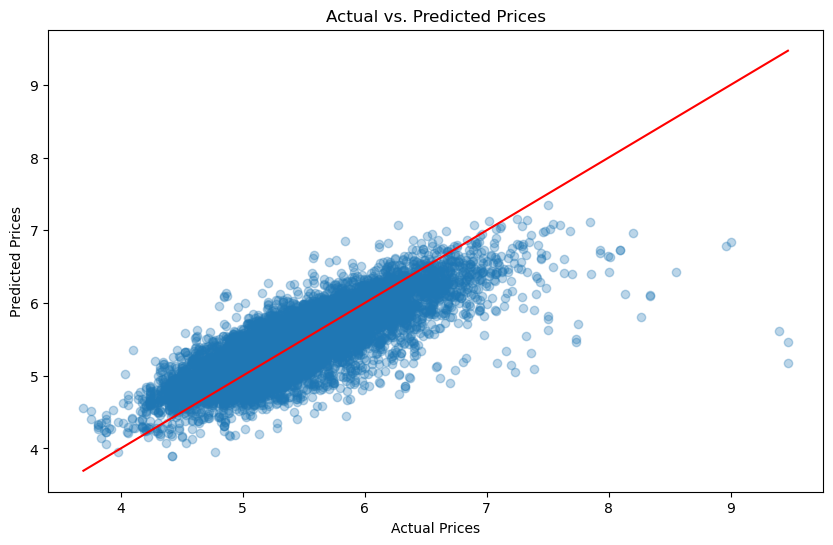

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Perfect predictions line
plt.show()

In [ ]:
model = xgb.XGBRegressor(objective ='reg:squarederror',
                         colsample_bytree = 0.3,
                         learning_rate = 0.1,
                         max_depth = 5,
                         alpha = 10,
                         n_estimators = 100)

In [ ]:
RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)